 a.Basic Object Detection Using OpenCV and Haar Cascades


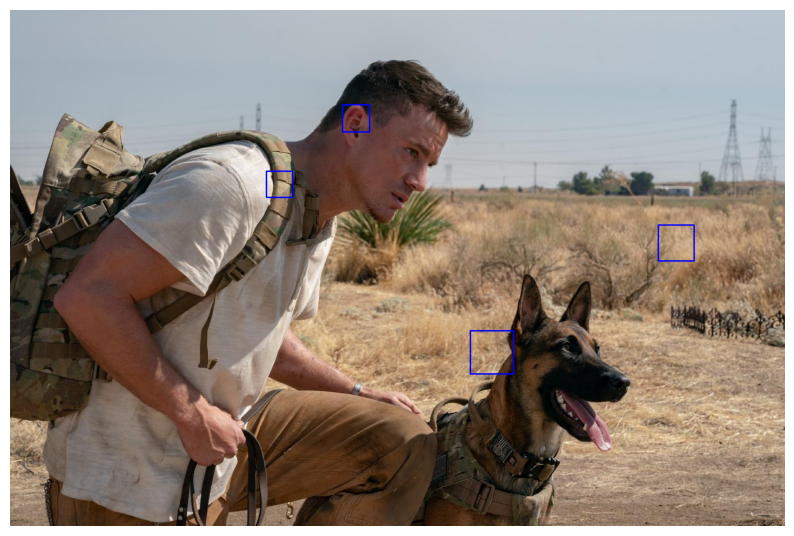

In [12]:
import cv2
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
img = cv2.imread('/kaggle/input/catcat/train/dogs/dog_10.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### b

In [13]:
!pip install opencv-python-headless
!pip install numpy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [14]:
!wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names

--2024-09-25 14:35:56--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: 'yolov3.weights'

yolov3.weights      100%[===================>] 236.52M  11.5MB/s    in 18s     

2024-09-25 14:36:14 (13.2 MB/s) - 'yolov3.weights' saved [248007048/248007048]

--2024-09-25 14:36:15--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: 'yolov3.cfg'

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

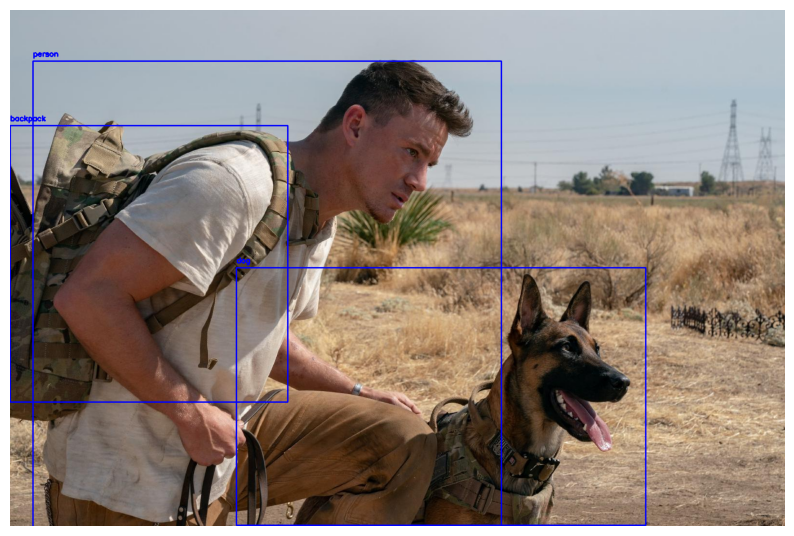

In [16]:
import cv2
import numpy as np

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
with open('coco.names', 'r') as f:
    classes = f.read().strip().split('\n')
    
img = cv2.imread('/kaggle/input/catcat/train/dogs/dog_10.jpg')
height, width, channels = img.shape

blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

outs = net.forward(output_layers)

class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## C.  MASK R-CNN FOR INSTANCE SEGMENTATION

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 194MB/s] 


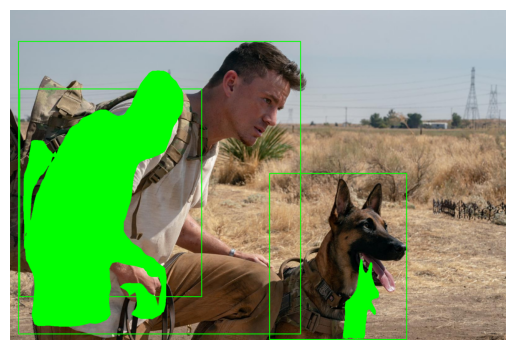

In [20]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Install necessary packages (for local execution)
# !pip install torch torchvision

# Load a pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load the image
image = cv2.imread("/kaggle/input/catcat/train/dogs/dog_10.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Transform the image to a tensor
image_tensor = F.to_tensor(image_rgb)

# Add a batch dimension
image_tensor = image_tensor.unsqueeze(0)

# Perform inference
with torch.no_grad():
    outputs = model(image_tensor)

# Get the masks, boxes, and labels
masks = outputs[0]['masks']
boxes = outputs[0]['boxes']
labels = outputs[0]['labels']
scores = outputs[0]['scores']

# Set the confidence threshold
conf_threshold = 0.5

# Loop over the detections
for i in range(len(masks)):
    if scores[i] > conf_threshold:
        # Extract the mask and bounding box
        mask = masks[i, 0].mul(255).byte().cpu().numpy()
        box = boxes[i].cpu().numpy().astype(int)
        label = labels[i].cpu().numpy()

        # Apply the mask to the image
        mask = cv2.resize(mask, (box[2] - box[0], box[3] - box[1]))
        mask = mask > 128

        roi = image[box[1]:box[3], box[0]:box[2]]
        roi[mask] = [0, 255, 0]

        # Draw the bounding box
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

# Convert BGR image to RGB for displaying with matplotlib
output_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the output image using matplotlib
plt.imshow(output_image)
plt.axis('off')  # Hide the axis
plt.show()
